In [354]:
import pandas as pd
import numpy as np
!pip install catboost
import catboost
import matplotlib.pyplot as plt
from datetime import datetime as dt

import seaborn as sns
#from sklearn.impute import KNNImputer
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import skew


# EDA

In [133]:
train_df = pd.read_csv('/content/drive/My Drive/House Price Competition/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/House Price Competition/test.csv')
submission_df = pd.read_csv('/content/drive/My Drive/House Price Competition/sample_submission.csv')


In [177]:
#missing features
train_df[train_df.columns[np.where(np.sum(train_df.isnull())>0)[0]]].isnull().sum()
train_df.loc[train_df.LotFrontage.isnull(),'LotFrontage']  = 0;train_df.loc[train_df.Fence.isnull(),'Fence']  = 'NF'
train_df.loc[train_df.Alley.isnull(),'Alley']  = 'NA';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';train_df.loc[train_df.GarageCond.isnull(),'GarageCond']  = 'NG'
train_df.loc[train_df.GarageQual.isnull(),'GarageQual']  = 'NG';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;train_df.loc[train_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
train_df.loc[train_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';train_df.loc[train_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
train_df.loc[train_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';train_df.loc[train_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
train_df.loc[train_df.MasVnrType.isnull(),'MasVnrType']  = 'none';train_df.loc[train_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
train_df.loc[train_df.PoolQC.isnull(),'PoolQC']  = 'NP';train_df.loc[train_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
train_df.loc[train_df.MiscFeature.isnull(),'MiscFeature']  = 'none';train_df.loc[train_df.Electrical.isnull(),'Electrical']  = 'Mix'

test_df[test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]].isnull().sum()
test_df.loc[test_df.LotFrontage.isnull(),'LotFrontage']  = 0;test_df.loc[test_df.Fence.isnull(),'Fence']  = 'NF'
test_df.loc[test_df.Alley.isnull(),'Alley']  = 'NA';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';test_df.loc[test_df.GarageCond.isnull(),'GarageCond']  = 'NG'
test_df.loc[test_df.GarageQual.isnull(),'GarageQual']  = 'NG';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;test_df.loc[test_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
test_df.loc[test_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';test_df.loc[test_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
test_df.loc[test_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';test_df.loc[test_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
test_df.loc[test_df.MasVnrType.isnull(),'MasVnrType']  = 'none';test_df.loc[test_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
test_df.loc[test_df.PoolQC.isnull(),'PoolQC']  = 'NP';test_df.loc[test_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
test_df.loc[test_df.MiscFeature.isnull(),'MiscFeature']  = 'none';test_df.loc[test_df.Electrical.isnull(),'Electrical']  = 'Mix'
test_df.loc[test_df.Utilities.isnull(),'MiscFeature'] = 

# for any still missing features use the mode of the feature on test
for c in test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]:
  test_df.loc[test_df[c].isnull(),c] = test_df[c].mode().values[0]


Series([], dtype: float64)

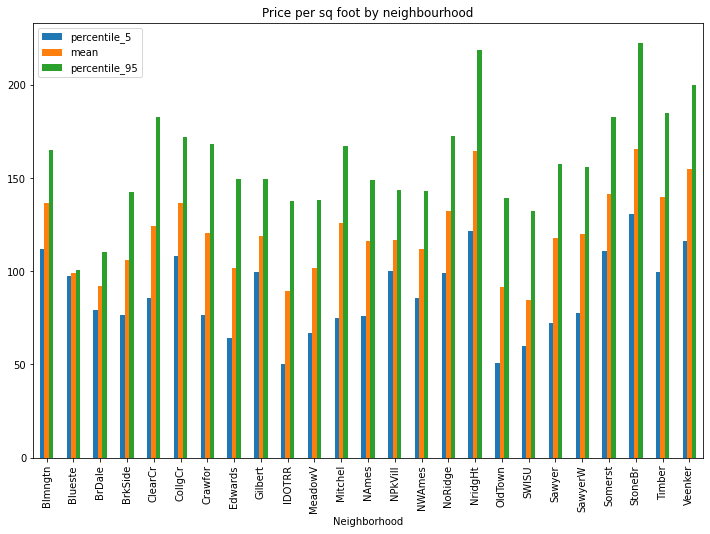

In [178]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in train_df.iterrows()]
train_df['GarageAge'] = train_df['YrSold'] - train_df['GarageYrBlt']

test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['GarageAge'] = test_df['YrSold'] - test_df['GarageYrBlt']
test_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in test_df.iterrows()]


train_df['PricePerSqFoot'] = train_df['SalePrice']/train_df['GrLivArea']

train_df.groupby('Neighborhood').PricePerSqFoot.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar')
fig = plt.gca()
fig.set_title('Price per sq foot by neighbourhood')
fig.figure.set_size_inches(12,8)

Clearly neighbourhood is a key feature.

In [179]:
neigh_ppqft = train_df.groupby(['Neighborhood']).PricePerSqFoot.mean().to_frame()
neigh_ppqft.rename(columns={'PricePerSqFoot':'NeighAvgPPSF'},inplace=True)
train_df = pd.merge(train_df,neigh_ppqft,on='Neighborhood',how='left')
train_df['DeltaPPSF'] = train_df.PricePerSqFoot - train_df.NeighAvgPPSF

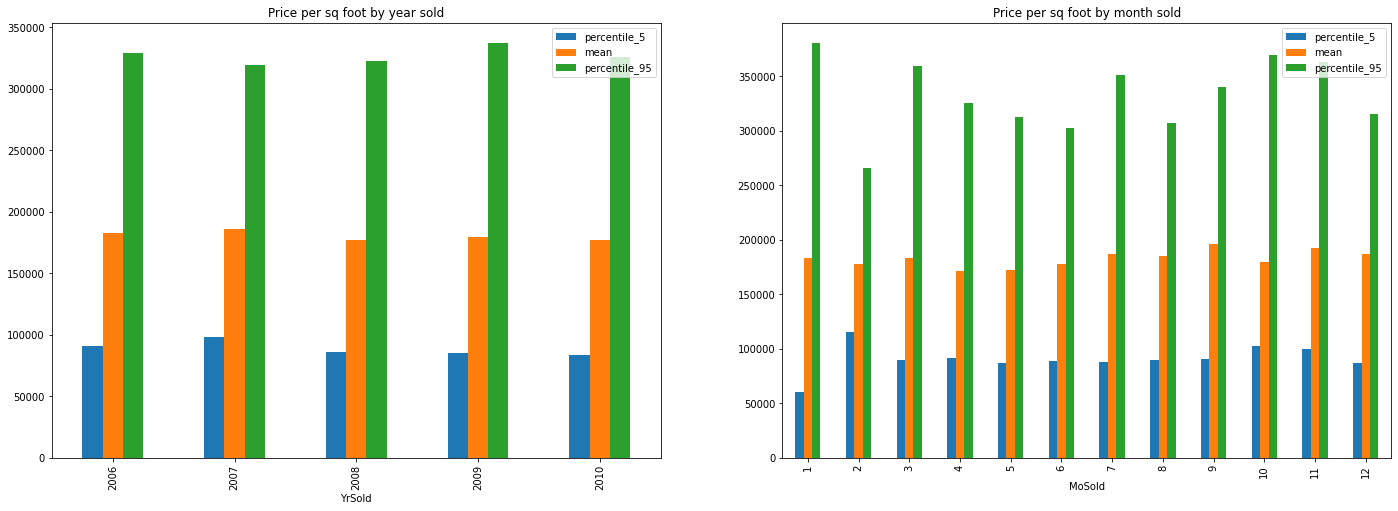

In [262]:
fig,axs = plt.subplots(1,2,figsize=(24,8))
train_df.groupby('YrSold').SalePrice.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar',ax=axs[0],title='Price per sq foot by year sold');
train_df.groupby('MoSold').SalePrice.agg([percentile(5),'mean',percentile(95)]).plot(kind='bar',ax=axs[1],title='Price per sq foot by month sold');

Surprisingly, year of sale doesn't appear to impact the price very much. There ia some seasonality evident with prices generally depressed in summer months.

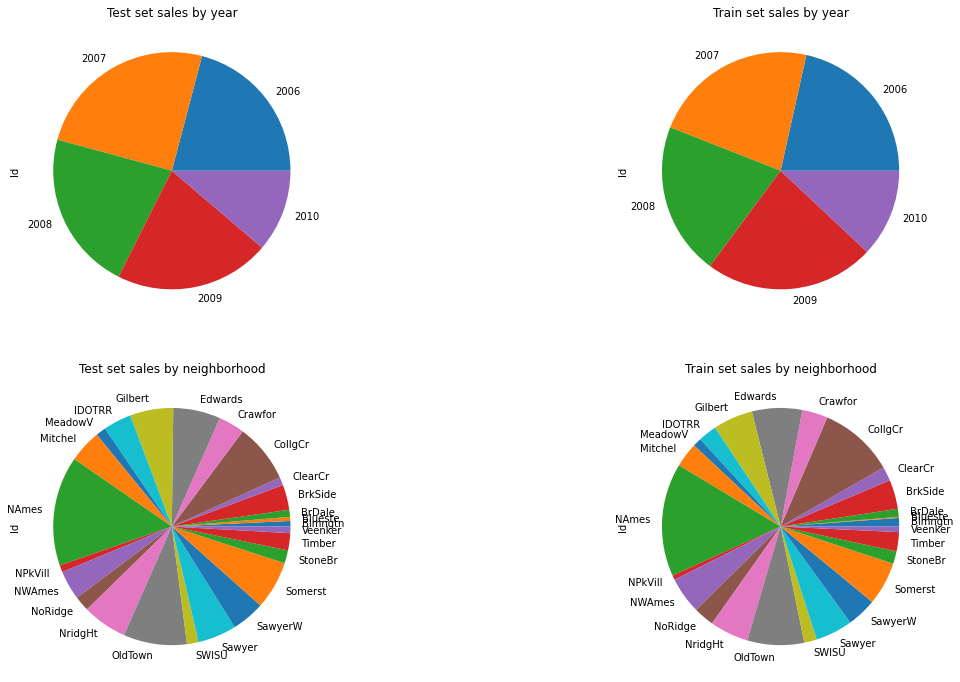

In [181]:
fig,axs = plt.subplots(2,2,figsize=(20,12));
test_df.groupby(['YrSold']).Id.count().plot.pie(ax=axs[0][0],title='Test set sales by year')
train_df.groupby(['YrSold']).Id.count().plot.pie(ax=axs[0][1],title='Train set sales by year')

test_df.groupby(['Neighborhood']).Id.count().plot.pie(ax = axs[1][0],title='Test set sales by neighborhood')
train_df.groupby(['Neighborhood']).Id.count().plot.pie(ax = axs[1][1],title='Train set sales by neighborhood')

Train and test have similar breakdowns by neighbourhood and year sold.

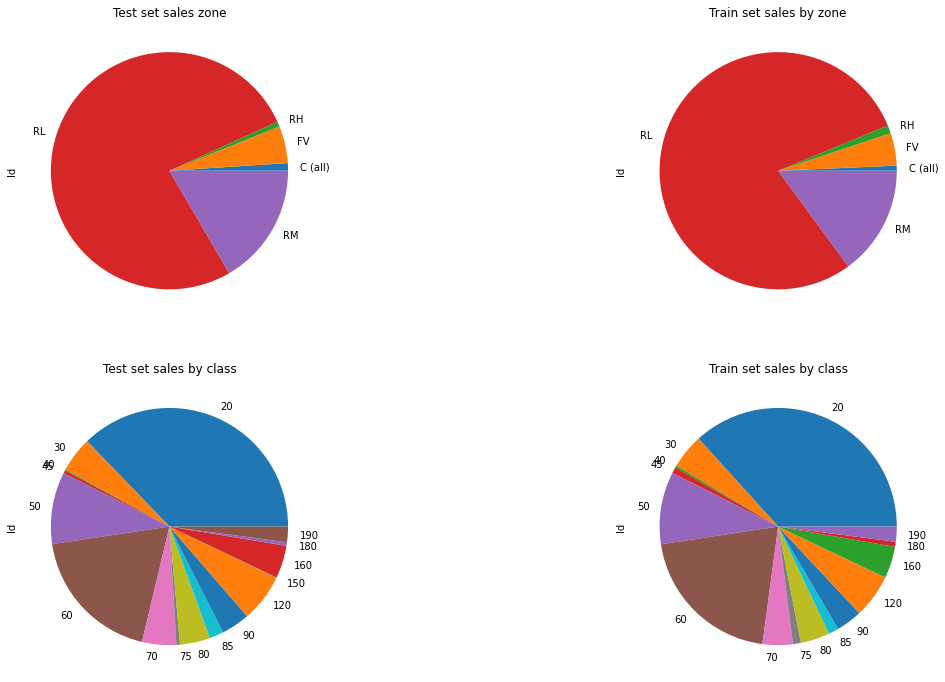

In [182]:
fig,axs = plt.subplots(2,2,figsize=(20,12));
test_df.groupby(['MSZoning']).Id.count().plot.pie(ax=axs[0][0],title='Test set sales zone');
train_df.groupby(['MSZoning']).Id.count().plot.pie(ax=axs[0][1],title='Train set sales by zone');

test_df.groupby(['MSSubClass']).Id.count().plot.pie(ax = axs[1][0],title='Test set sales by class');
train_df.groupby(['MSSubClass']).Id.count().plot.pie(ax = axs[1][1],title='Train set sales by class');


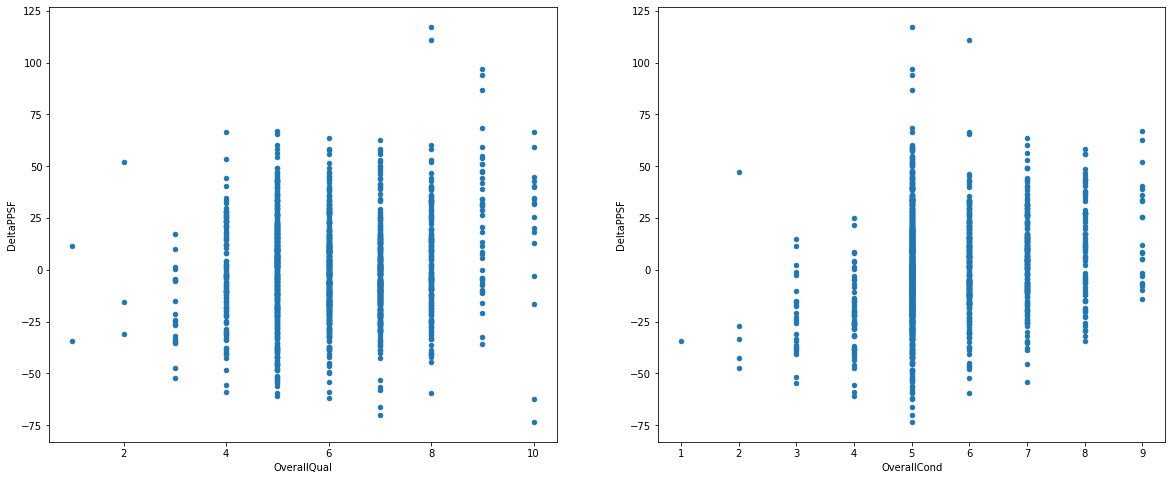

In [183]:
fig,axs = plt.subplots(1,2,figsize=(20,8));
train_df.plot.scatter(x='OverallQual',y='DeltaPPSF',ax=axs[0]);
train_df.plot.scatter(x='OverallCond',y='DeltaPPSF',ax=axs[1]);

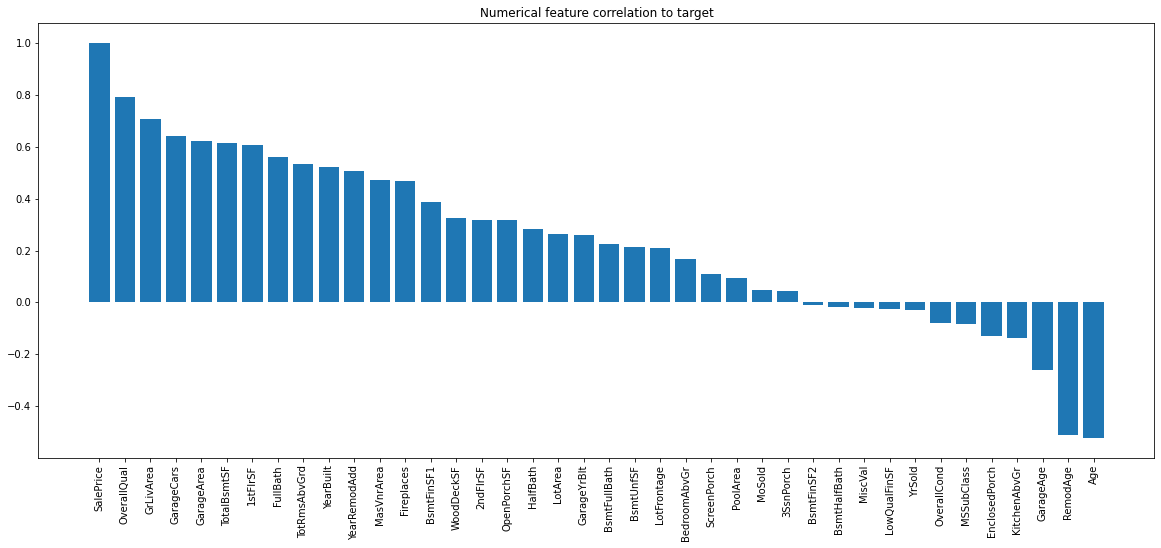

In [271]:
#Identify the datatype of variables

categorical_features = train_df.columns[np.where((train_df.dtypes == np.object))[0]].values
numerical_features = train_df.columns[np.where((train_df.dtypes != np.object))[0]].values
numerical_features = numerical_features[~np.isin(numerical_features,['Id','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','DateSold'])]
num_feat_corrs = np.array([np.corrcoef(train_df.SalePrice,train_df[f])[0,1] for f in numerical_features])
idx = np.argsort(num_feat_corrs)[::-1]
fig,axs = plt.subplots(1,1,figsize=(20,8))
plt.bar(numerical_features[idx],num_feat_corrs[idx])
plt.xticks(rotation=90);
plt.title('Numerical feature correlation to target');

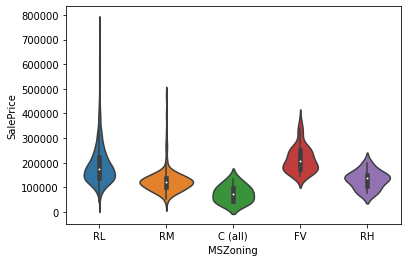

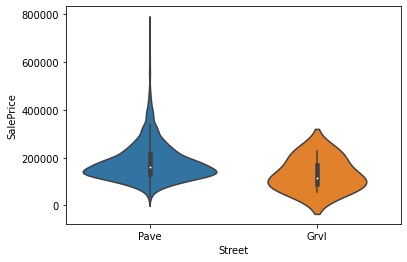

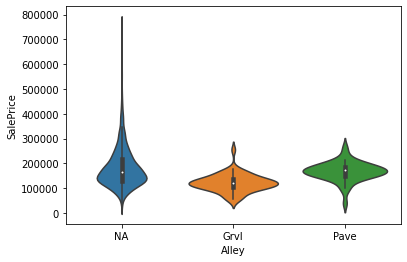

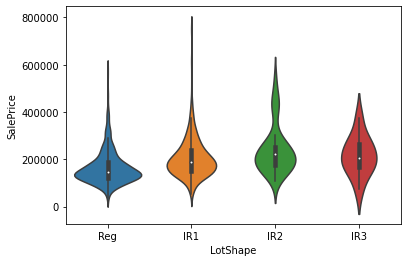

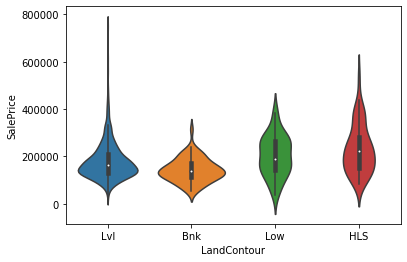

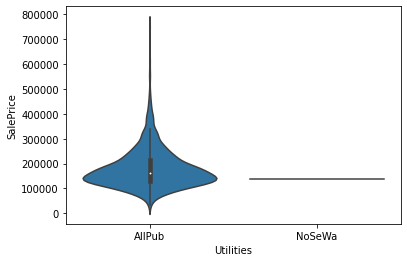

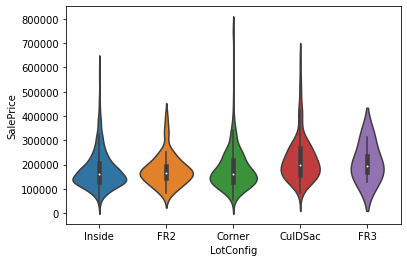

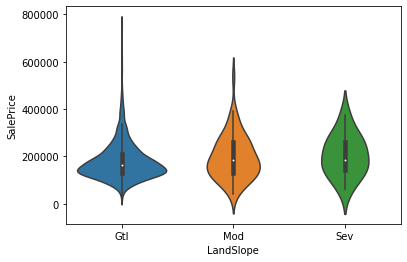

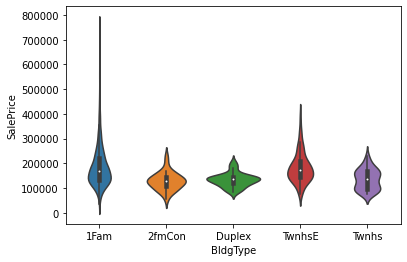

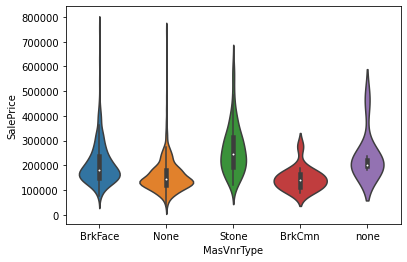

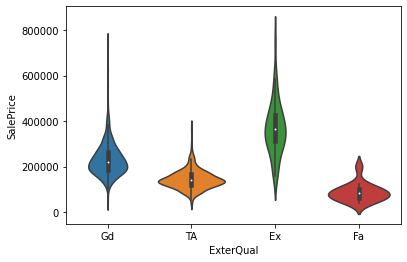

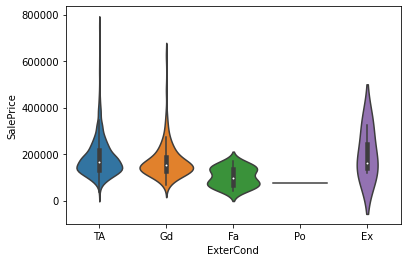

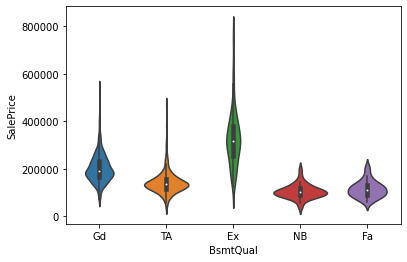

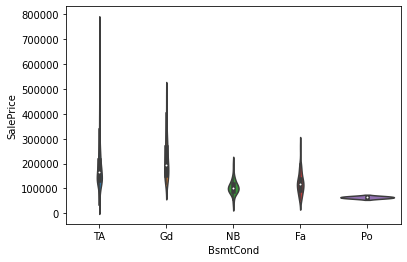

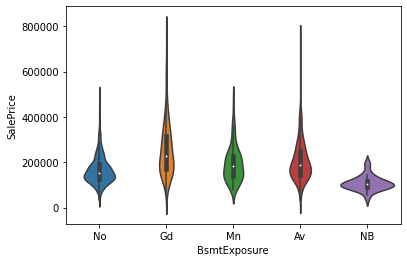

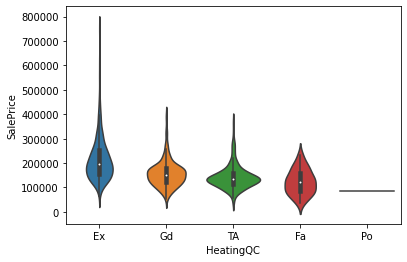

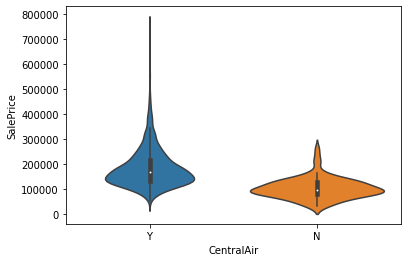

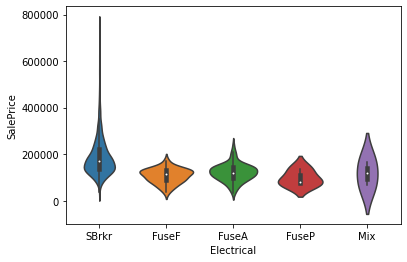

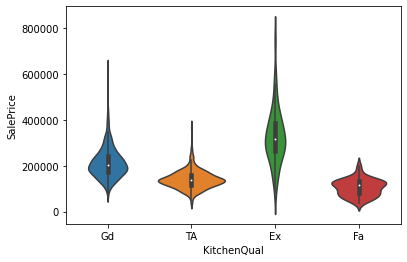

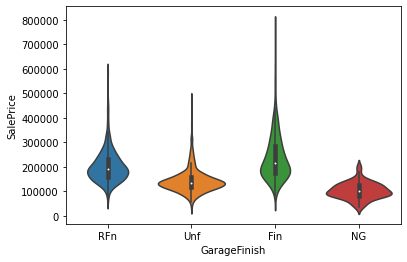

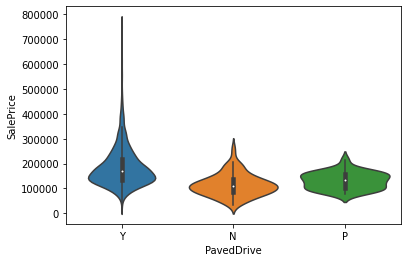

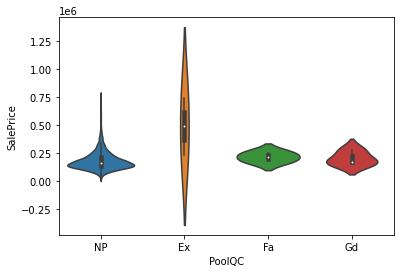

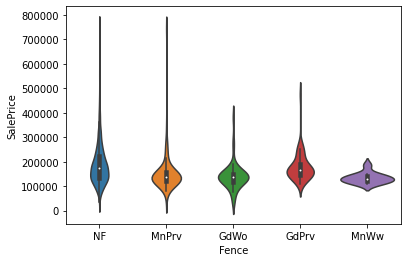

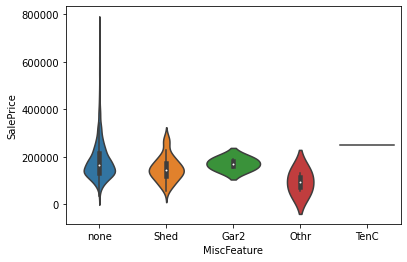

In [268]:
for f in categorical_features[np.array([train_df[f].nunique() for f in categorical_features])<6]:
  sns.violinplot(x=f,y='SalePrice',data=train_df)
  plt.show()



# Data Preparation  

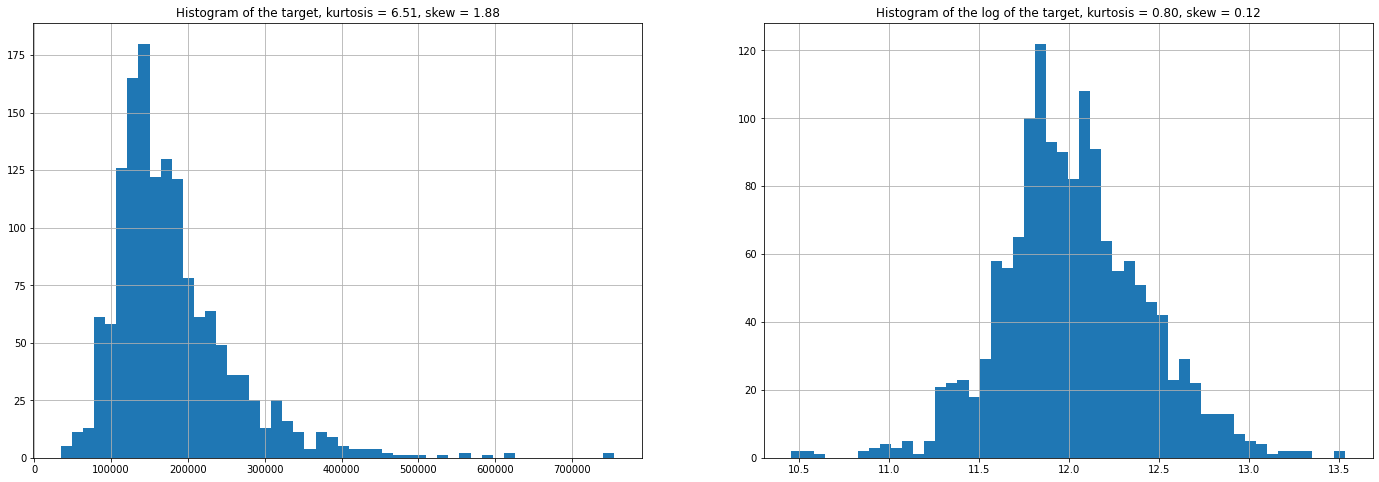

In [358]:
X = train_df.drop(['Id','SalePrice','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
y = train_df.SalePrice
X_submit = test_df.drop(['Id','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
X_oh = pd.get_dummies(X,columns=categorical_features)


from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)
X_train_oh, X_validation_oh, y_train, y_validation = train_test_split(X_oh, y, train_size=0.8, random_state=1234)

xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()
X_train_oh = xStandardScaler.fit_transform(X_train_oh)
X_validation_oh = xStandardScaler.transform(X_validation_oh)

y_train = yStandardScaler.fit_transform(y_train.ravel().reshape(-1, 1))
y_validation = yStandardScaler.transform(y_validation.ravel().reshape(-1, 1))

fig,axs = plt.subplots(1,2,figsize=(24,8));
y.hist(bins=50,ax=axs[0]);axs[0].set_title('Histogram of the target, kurtosis = {:.2f}, skew = {:.2f}'.format(kurtosis(y),skew(y)));
np.log(y).hist(bins=50,ax=axs[1]);axs[1].set_title('Histogram of the log of the target, kurtosis = {:.2f}, skew = {:.2f}'.format(kurtosis(np.log(y)),skew(np.log(y))));

y_train = np.log(y_train)
y_validation = np.log(y_validation)

The distribution of the target looks lognormal so I will apply a tranformation. In fact the log of the target still displays excess kurtosis but it is closer to normal and the skew is much lower


In [349]:
kurtosis(np.log(y))
kurtosis(y)
y.skew()
np.log(y).skew()
x = np.random.normal(0,1,1000)
kurtosis(x)
stat, p = shapiro(y)
stat, p = shapiro(np.log(y))


0.061836748377339656

# CatBoost

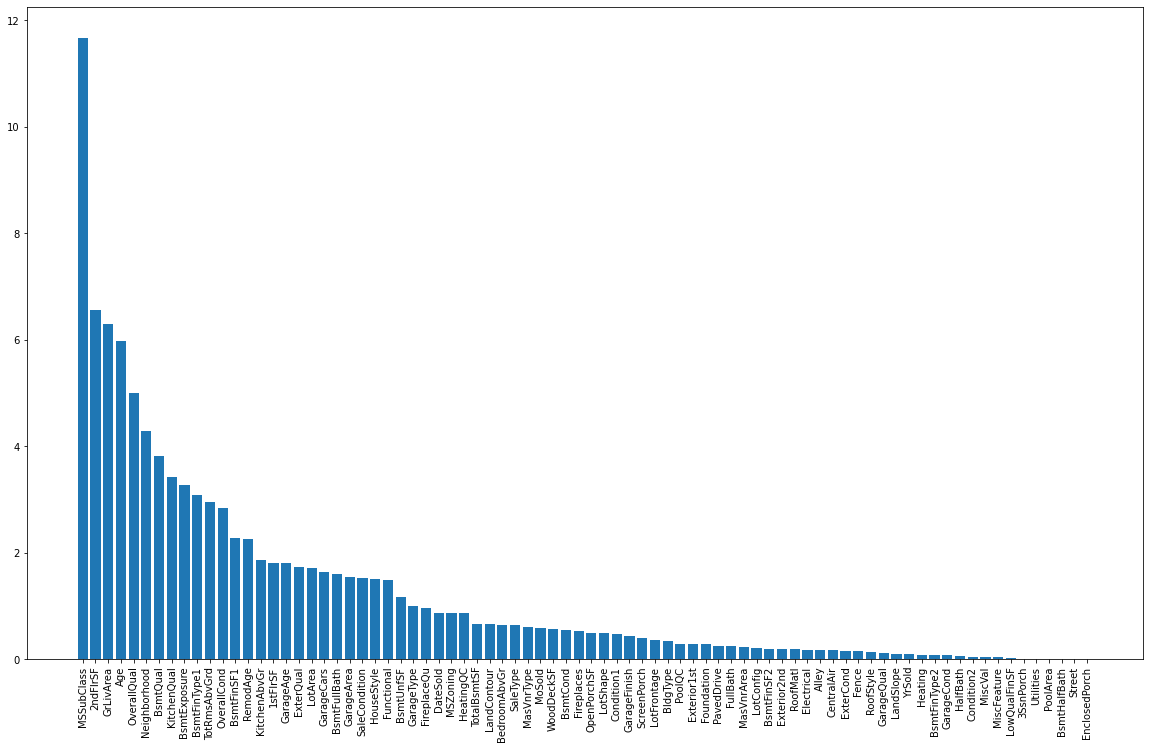

In [200]:
#importing library and building model
categorical_features_indices = np.where(X.columns.isin(categorical_features))[0]
from catboost import CatBoostRegressor
mode_cat_boost=CatBoostRegressor(iterations=200, depth=7, learning_rate=0.05, loss_function='RMSE')
history = model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)
plt.plot(history.evals_result_['learn']['RMSE'])
plt.plot(history.evals_result_['validation']['RMSE'])

idx = np.argsort(model.get_feature_importance())[::-1]
fig,ax = plt.subplots(1,1,figsize=(20,12))
plt.bar(X_train.columns[idx],np.sort(model.get_feature_importance())[::-1])
plt.xticks(rotation=90);


In [14]:
pred = model.predict(X_submit)

submission_df['SalePrice'] = pred
submission_df.to_csv('Sumission_003.csv',index=False)


In [ ]:
X_psf = train_df.drop(columns=['Id','SalePrice','PricePerSqFoot','NeighAvgPPSF','DeltaPPSF','YearBuilt','YearRemodAdd','GarageYrBlt'])
y_psf = train_df.PricePerSqFoot

X_train_psf, X_validation_psf, y_train_psf, y_validation_psf = train_test_split(X_psf, y_psf, train_size=0.7, random_state=1234)

categorical_features_indices = np.where(X_psf.columns.isin(categorical_features))[0]
model_psf=CatBoostRegressor(iterations=1000, depth=7, learning_rate=0.05, loss_function='RMSE')
history = model_psf.fit(X_train_psf, y_train_psf,cat_features=categorical_features_indices,eval_set=(X_validation_psf, y_validation_psf),plot=True)
plt.plot(history.evals_result_['learn']['RMSE'])
plt.plot(history.evals_result_['validation']['RMSE'])

In [199]:
pred = model.predict(X_submit)
submission_df['SalePrice'] = X_submit.GrLivArea * pred
submission_df.to_csv('Sumission_005.csv',index=False)
